# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  # ResNet model
from tensorflow.keras.applications.resnet import preprocess_input  # Required for ResNet preprocessing
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt  # Needed for visualization


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

print(tf.config.list_physical_devices('GPU'))



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Image path for training

In [3]:
images_path = "dataverse_files/HAM10000_images_combined_600x450/"
metadata_path = "dataverse_files/HAM10000_metadata"
mask_path = "dataverse_files/HAM10000_segmentations_lesion/"

In [4]:
metadata = pd.read_csv(metadata_path)
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(images_path, f"{x}.jpg"))
metadata['mask_path'] = metadata['image_id'].apply(lambda x: os.path.join(mask_path, f"{x}_segmentation.png"))

# Preprocessing Data

In [5]:
train, test = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)
train, val = train_test_split(train, test_size=0.2, stratify=train['dx'], random_state=42)

In [6]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train['dx']), y=train['dx'])
class_weights_dict = {idx: weight for idx, weight in enumerate(class_weights)}

In [7]:
# Label mapping
label_mapping = {label: idx for idx, label in enumerate(sorted(train['dx'].unique()))}
train['dx'] = train['dx'].map(label_mapping)
val['dx'] = val['dx'].map(label_mapping)
test['dx'] = test['dx'].map(label_mapping)

In [8]:
# Preprocessing function
def preprocess_image_and_mask(image_path, mask_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Failed to load image: {image_path}")
    image = cv2.resize(image, target_size) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Failed to load mask: {mask_path}")
    mask = cv2.resize(mask, target_size) / 255.0

    masked_image = np.multiply(image, np.expand_dims(mask, axis=-1))
    return masked_image

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [10]:
def masked_image_generator(data, batch_size=32, target_size=(224, 224), augment=False):
    while True:
        for start in range(0, len(data), batch_size):
            batch_data = data.iloc[start:start+batch_size]
            batch_images, batch_labels = [], []

            for _, row in batch_data.iterrows():
                try:
                    masked_image = preprocess_image_and_mask(row['image_path'], row['mask_path'], target_size)
                    if augment:
                        masked_image = train_datagen.random_transform(masked_image)
                    batch_images.append(masked_image)
                    batch_labels.append(row['dx'])
                except FileNotFoundError:
                    continue  # Skip missing images

            yield np.array(batch_images), tf.keras.utils.to_categorical(batch_labels, num_classes=len(label_mapping))

In [11]:
train_generator = masked_image_generator(train, batch_size=32, target_size=(224, 224), augment=True)
val_generator = masked_image_generator(val, batch_size=32, target_size=(224, 224), augment=False)

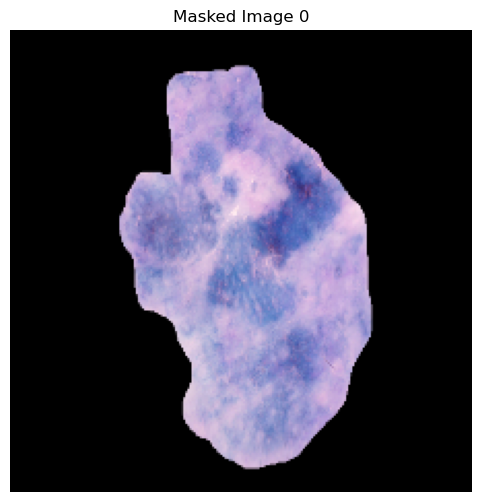

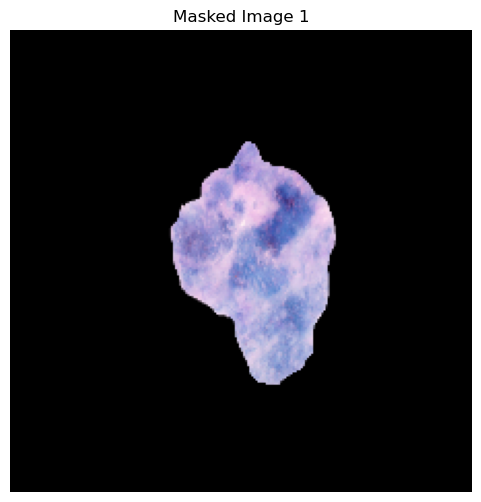

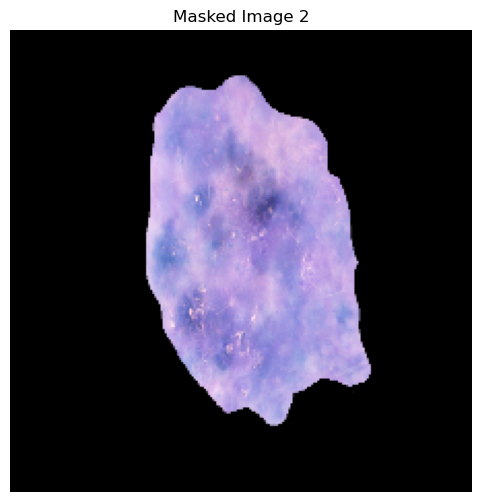

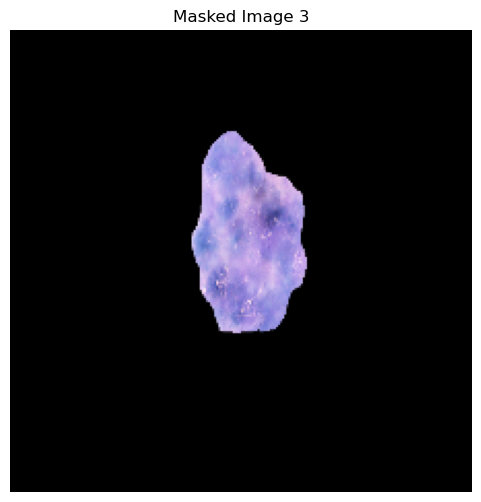

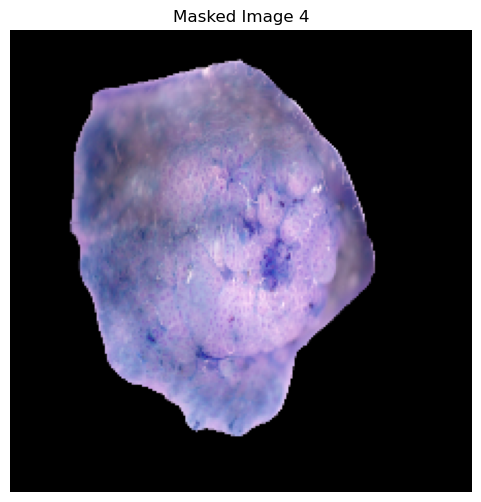

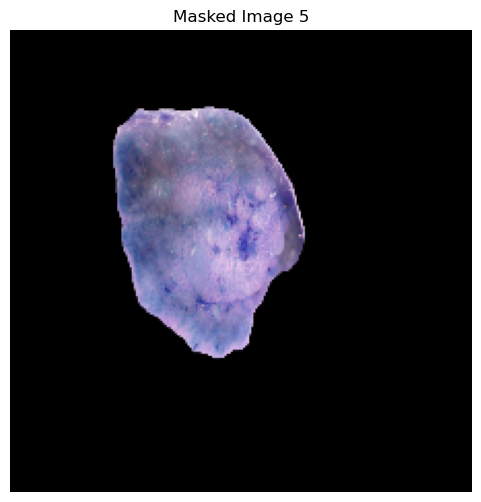

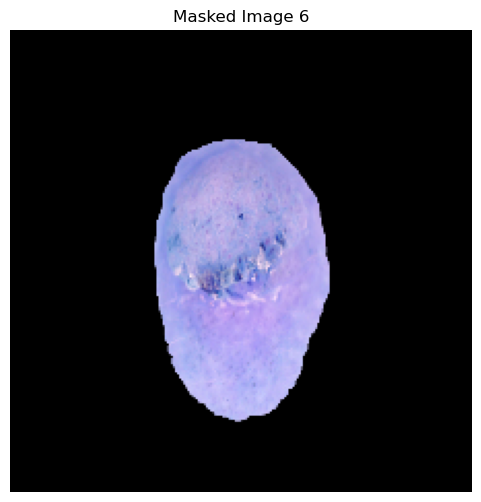

In [12]:
import matplotlib.pyplot as plt

for idx, row in metadata.iterrows():
    image_path = row['image_path']
    mask_path = row['mask_path']

    try:
        # Preprocess image and mask
        masked_image = preprocess_image_and_mask(image_path, mask_path)  # Only masked_image

        # Display the masked image
        plt.figure(figsize=(6, 6))
        plt.imshow((masked_image - masked_image.min()) / (masked_image.max() - masked_image.min()))
        plt.title(f"Masked Image {idx}")
        plt.axis("off")
        plt.show()

        # Break after visualizing a few examples (optional)
        if idx > 5:  # Display 6 examples
            break

    except FileNotFoundError as e:
        print(e)

# Resnet-50 model


In [28]:
### 1st

# Load ResNet-50 Model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze Last 50 Layers
for layer in resnet_base.layers[-50:]:
    layer.trainable = True

# Add Custom Classifier
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(len(label_mapping), activation='softmax')(x)

# Create ResNet Model
resnet_model = Model(inputs=resnet_base.input, outputs=output)

# Compile Model
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Step 1: Train Top Layers (Warm-up)
for layer in resnet_base.layers:
    layer.trainable = False  # Freeze all layers

resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(train) // 32,
    validation_data=val_generator,
    validation_steps=len(val) // 32,
    epochs=10,  # Warm-up training
    callbacks=[early_stopping, reduce_lr]
)

# Step 2: Unfreeze More Layers for Fine-Tuning
for layer in resnet_base.layers[-100:]:  # Now unfreeze the last 100 layers
    layer.trainable = True

# Recompile with Lower Learning Rate
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 3: Fine-Tune Model
resnet_history_finetune = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(train) // 32,
    validation_data=val_generator,
    validation_steps=len(val) // 32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
200/200 [==============================] - 118s 565ms/step - loss: 11.3741 - accuracy: 0.2067 - val_loss: 16.3891 - val_accuracy: 0.1088 - lr: 1.0000e-04
Epoch 2/10
200/200 [==============================] - 113s 565ms/step - loss: 9.6860 - accuracy: 0.4286 - val_loss: 36.9328 - val_accuracy: 0.0481 - lr: 1.0000e-04
Epoch 3/10
200/200 [==============================] - 115s 578ms/step - loss: 8.5501 - accuracy: 0.6124 - val_loss: 2837.6704 - val_accuracy: 0.0119 - lr: 1.0000e-04
Epoch 4/10
200/200 [==============================] - 115s 574ms/step - loss: 7.7022 - accuracy: 0.6323 - val_loss: 27693.0254 - val_accuracy: 0.1100 - lr: 1.0000e-04
Epoch 5/10
200/200 [==============================] - 111s 558ms/step - loss: 7.1324 - accuracy: 0.6367 - val_loss: 149298.8125 - val_accuracy: 0.0331 - lr: 5.0000e-05
Epoch 6/10
200/200 [==============================] - 112s 560ms/step - loss: 6.7529 - accuracy: 0.6506 - val_loss: 452399.9062 - val_accuracy: 0.0331 - lr: 5.0000e-05
Ep

In [29]:
def combine_histories(history1, history2):
    combined_history = {
        'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
        'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
        'loss': history1.history['loss'] + history2.history['loss'],
        'val_loss': history1.history['val_loss'] + history2.history['val_loss']
    }
    return combined_history

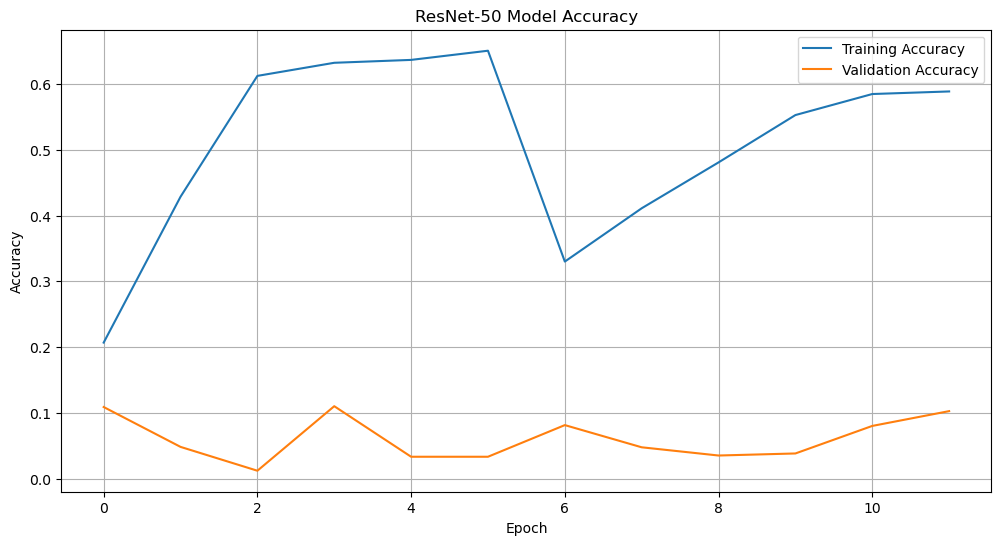

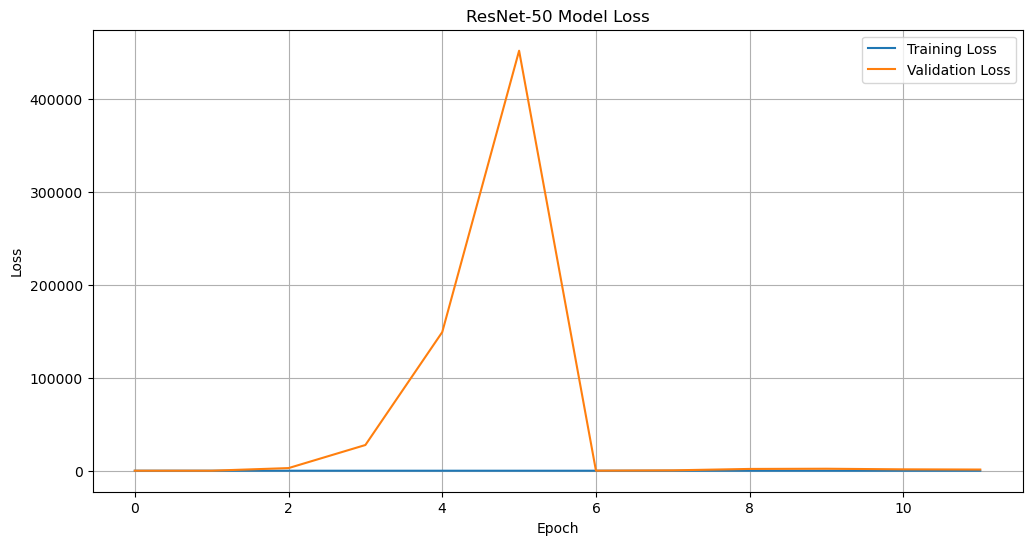

In [30]:
combined_history_resnet = combine_histories(resnet_history, resnet_history_finetune)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(combined_history_resnet['accuracy'], label='Training Accuracy')
plt.plot(combined_history_resnet['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet-50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(combined_history_resnet['loss'], label='Training Loss')
plt.plot(combined_history_resnet['val_loss'], label='Validation Loss')
plt.title('ResNet-50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

ResNet50 Model Test Results


*   List item
*   List item



In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure we store true labels and predictions
y_true = []
y_pred = []

# Create a test data generator
test_generator = masked_image_generator(test, batch_size=32, target_size=(224, 224), augment=False)

# Iterate over the test set and get predictions
for images, labels in test_generator:
    preds = resnet_model.predict(images)  # Model predictions
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot labels to class indices
    y_pred.extend(np.argmax(preds, axis=1))  # Convert softmax outputs to class indices

    if len(y_true) >= len(test):  # Stop when we have covered all test samples
        break

1/1 [==============================] - 1s 955ms/step


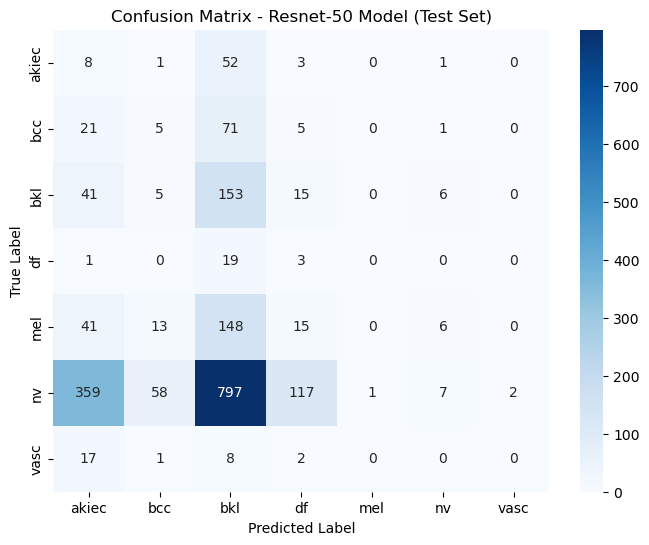

In [32]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true[:len(test)], y_pred[:len(test)])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Resnet-50 Model (Test Set)")
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

class_report = classification_report(y_true[:len(test)], y_pred[:len(test)], target_names=label_mapping.keys())

# Print classification report
print("Classification Report - Resnet-50 Model (Test Set):\n")
print(class_report)

Classification Report - Resnet-50 Model (Test Set):

              precision    recall  f1-score   support

       akiec       0.02      0.12      0.03        65
         bcc       0.06      0.05      0.05       103
         bkl       0.12      0.70      0.21       220
          df       0.02      0.13      0.03        23
         mel       0.00      0.00      0.00       223
          nv       0.33      0.01      0.01      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.09      2003
   macro avg       0.08      0.14      0.05      2003
weighted avg       0.24      0.09      0.03      2003



In [34]:
test_metadata_path = "dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv"
test_images_path = "dataverse_files/ISIC2018_Task3_Test_Images/"
test_metadata = pd.read_csv(test_metadata_path)

In [35]:
def get_image_path(image_id):
    path = os.path.join(test_images_path, f"{image_id}.jpg")
    if not os.path.exists(path):
        print(f"Warning: File not found - {path}")
        return None
    return path

In [36]:
test_metadata['image_path'] = test_metadata['image_id'].apply(get_image_path)
test_metadata = test_metadata.dropna(subset=['image_path'])
print(f"Remaining test images: {len(test_metadata)}")
print(test_metadata.head())

Remaining test images: 1511
         lesion_id      image_id   dx    dx_type   age     sex localization   
0  HAMTEST_0000000  ISIC_0034524   nv  follow_up  40.0  female         back  \
1  HAMTEST_0000001  ISIC_0034525   nv      histo  70.0    male      abdomen   
2  HAMTEST_0000002  ISIC_0034526  bkl      histo  70.0    male         back   
3  HAMTEST_0000003  ISIC_0034527   nv      histo  35.0    male        trunk   
4  HAMTEST_0000004  ISIC_0034528   nv  follow_up  75.0  female        trunk   

         dataset                                         image_path  
0  vidir_molemax  dataverse_files/ISIC2018_Task3_Test_Images/ISI...  
1      rosendahl  dataverse_files/ISIC2018_Task3_Test_Images/ISI...  
2      rosendahl  dataverse_files/ISIC2018_Task3_Test_Images/ISI...  
3    vienna_dias  dataverse_files/ISIC2018_Task3_Test_Images/ISI...  
4  vidir_molemax  dataverse_files/ISIC2018_Task3_Test_Images/ISI...  


In [37]:
label_mapping = {label: idx for idx, label in enumerate(sorted(test_metadata['dx'].unique()))}
test_metadata['dx_numeric'] = test_metadata['dx'].map(label_mapping)

In [38]:
def preprocess_test_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load and resize image
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array

In [39]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

test_images = []
test_labels = []

for _, row in test_metadata.iterrows():
    image_path = os.path.join(test_images_path, f"{row['image_id']}.jpg")
    test_images.append(preprocess_test_image(image_path))
    test_labels.append(row['dx_numeric'])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

num_classes = 7

if len(test_labels.shape) == 1:  # If labels are (num_samples,)
    test_labels_one_hot = to_categorical(test_labels, num_classes=num_classes)

test_labels_one_hot = to_categorical(test_labels, num_classes=len(label_mapping))

In [40]:
print("Test Images Shape:", test_images.shape)  # Should be (num_samples, 224, 224, 3)

Test Images Shape: (1511, 224, 224, 3)


In [41]:
test_loss, test_accuracy = resnet_model.evaluate(test_images, test_labels_one_hot, batch_size=32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

48/48 [==============================] - 3s 64ms/step - loss: 78.0960 - accuracy: 0.1343
Test Loss: 78.09603118896484
Test Accuracy: 0.13434810936450958


In [42]:
image_path = "dataverse_files/ISIC2018_Task3_Test_Images/ISIC_0036063.jpg"

image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")
image = cv2.resize(image, (224, 224))
image = image / 255.0
image = np.expand_dims(image, axis=0)

In [43]:
prediction_v1 = resnet_model.predict(image)
predicted_class_v1 = np.argmax(prediction_v1, axis=1)[0]
for category, label in label_mapping.items():
    if label == predicted_class_v1:
        print(f"The image belongs to the category: {category}")
        break

1/1 [==============================] - 0s 82ms/step
The image belongs to the category: bkl


In [44]:
image_path = "dataverse_files/ISIC2018_Task3_Test_Images/ISIC_0034911.jpg"

image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")
image = cv2.resize(image, (224, 224))
image = image / 255.0
image = np.expand_dims(image, axis=0)

In [45]:
prediction_v2 = resnet_model.predict(image)
predicted_class_v2 = np.argmax(prediction_v2, axis=1)[0]
for category, label in label_mapping.items():
    if label == predicted_class_v2:
        print(f"The image belongs to the category: {category}")
        break

1/1 [==============================] - 0s 24ms/step
The image belongs to the category: bkl


In [46]:
resnet_model.save('resnet_model.h5')
resnet_model.save('resnet_model.keras')

# Feature Extraction

In [14]:
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Directory to store saved models
model_save_path = "saved_models/"
os.makedirs(model_save_path, exist_ok=True)

# Load ResNet-50 for feature extraction (trained model should be used if available)
resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet_base.input, outputs=resnet_base.layers[-5].output)

# Function to preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    image = cv2.resize(image, target_size) / 255.0  # Resize and normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to extract deep features
def extract_features(data, batch_size=32):
    features, labels = [], []

    for start in range(0, len(data), batch_size):
        batch_data = data.iloc[start:start+batch_size]
        batch_images, batch_labels = [], []

        for _, row in batch_data.iterrows():
            try:
                image = preprocess_image(row['image_path'])
                batch_images.append(image)
                batch_labels.append(row['dx'])
            except FileNotFoundError:
                continue  # Skip missing images

        if batch_images:
            batch_images = np.vstack(batch_images)
            batch_features = feature_extractor.predict(batch_images)
            features.append(batch_features)
            labels.extend(batch_labels)

    return np.vstack(features).reshape(len(labels), -1), np.array(labels)

def extract_masked_features(data, batch_size=32):
    features, labels = [], []

    for start in range(0, len(data), batch_size):
        batch_data = data.iloc[start:start+batch_size]
        batch_images, batch_labels = [], []

        for _, row in batch_data.iterrows():
            try:
                masked_image = preprocess_image_and_mask(row['image_path'], row['mask_path'])
                batch_images.append(np.expand_dims(masked_image, axis=0))  # Add batch dimension
                batch_labels.append(row['dx'])
            except FileNotFoundError:
                continue  # Skip missing images

        if batch_images:
            batch_images = np.vstack(batch_images)  # Stack images
            batch_features = feature_extractor.predict(batch_images)  # Extract deep features
            features.append(batch_features)
            labels.extend(batch_labels)

    return np.vstack(features).reshape(len(labels), -1), np.array(labels)

# Extract features
X_train_features, y_train = extract_features(train)
X_val_features, y_val = extract_features(val)
X_test_features, y_test = extract_features(test)

X_train_masked_features, y_train_masked = extract_masked_features(train)
X_val_masked_features, y_val_masked = extract_masked_features(val)
X_test_masked_features, y_test_masked = extract_masked_features(test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)
X_test_scaled = scaler.transform(X_test_features)

scaler_masked = StandardScaler()
X_train_masked_scaled = scaler_masked.fit_transform(X_train_masked_features)
X_val_masked_scaled = scaler_masked.transform(X_val_masked_features)
X_test_masked_scaled = scaler_masked.transform(X_test_masked_features)

# Save scaler for future predictions
joblib.dump(scaler, os.path.join(model_save_path, "scaler.pkl"))
joblib.dump(scaler_masked, os.path.join(model_save_path, "scaler_masked.pkl"))

1/1 [==============================] - 0s 26ms/step


['saved_models/scaler_masked.pkl']

# SVM Model 1 (Poly)

In [50]:
# Define hyperparameter grid
param_grid = {
    'C': [1, 2],
    'gamma': [0.001, 0.005],
    'kernel': ['poly']
}

cv_values = [3, 5]  # Different cross-validation values
saved_models = {}  # Store best models


for cv_folds in cv_values:
    print(f"\nRunning Fine-Tuned Grid Search with cv={cv_folds}")

    grid_search = GridSearchCV(
        SVC(class_weight='balanced'),
        param_grid,
        cv=cv_folds,
        scoring='accuracy',
        n_jobs=4,
        verbose=2
    )

    grid_search.fit(X_train_scaled, y_train)

    # Get best parameters and validation accuracy
    best_params = grid_search.best_params_
    best_val_accuracy = grid_search.best_score_

    print(f"\nBest Parameters for cv={cv_folds}: {best_params}")
    print(f"Best Validation Accuracy for cv={cv_folds}: {best_val_accuracy:.4f}")

    # Save best model
    best_svm = grid_search.best_estimator_
    model_filename = os.path.join(model_save_path, f"poly_svm_cv{cv_folds}.pkl")
    joblib.dump(best_svm, model_filename)
    saved_models[cv_folds] = best_svm

    # Evaluate on test set
    y_pred_best_svm = best_svm.predict(X_test_scaled)
    best_svm_accuracy = accuracy_score(y_test, y_pred_best_svm)

    print(f"Best Fine-Tuned SVM Test Accuracy for cv={cv_folds}: {best_svm_accuracy:.4f}")



Running Fine-Tuned Grid Search with cv=3
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best Parameters for cv=3: {'C': 1, 'gamma': 0.005, 'kernel': 'poly'}
Best Validation Accuracy for cv=3: 0.6616
Best Fine-Tuned SVM Test Accuracy for cv=3: 0.6830

Running Fine-Tuned Grid Search with cv=5
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters for cv=5: {'C': 2, 'gamma': 0.001, 'kernel': 'poly'}
Best Validation Accuracy for cv=5: 0.6659
Best Fine-Tuned SVM Test Accuracy for cv=5: 0.6865


In [51]:
# Get unique predicted classes
unique_predictions = np.unique(y_pred_best_svm)
print(f"Unique Predicted Classes: {unique_predictions}")

# Ensure all classes are represented
print(f"Number of Classes in Test Set: {len(np.unique(y_test))}")


Unique Predicted Classes: [0 1 2 3 4 5 6]
Number of Classes in Test Set: 7


# SVM Model 1 Test Results

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to load a model, predict, and generate a confusion matrix
def evaluate_svm_model(model_path, X_test_scaled, y_test, title="Confusion Matrix"):
    # Load the trained SVM model
    svm_model = joblib.load(model_path)

    # Predict on the test set
    y_pred = svm_model.predict(X_test_scaled)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy for {model_path}: {accuracy:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.title(f"{title} (Accuracy: {accuracy:.4f})")
    plt.show()

    return cm

Test Accuracy for saved_models/poly_svm_cv3.pkl: 0.6830


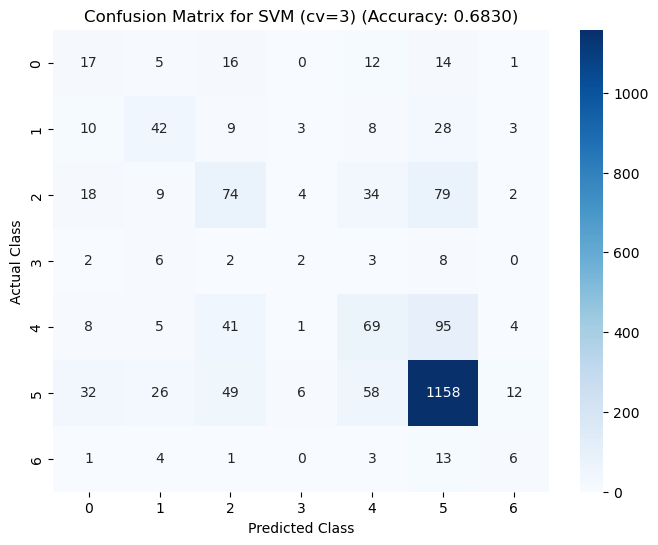

Test Accuracy for saved_models/poly_svm_cv5.pkl: 0.6865


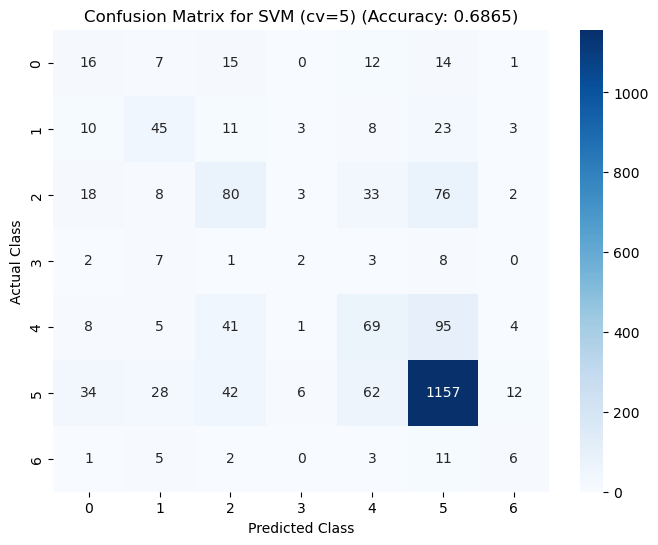

In [53]:
# Paths to saved models
svm_cv3_path = "saved_models/poly_svm_cv3.pkl"
svm_cv5_path = "saved_models/poly_svm_cv5.pkl"

# Evaluate SVM trained with cv=3
cm_cv3 = evaluate_svm_model(svm_cv3_path, X_test_scaled, y_test, title="Confusion Matrix for SVM (cv=3)")

# Evaluate SVM trained with cv=5
cm_cv5 = evaluate_svm_model(svm_cv5_path, X_test_scaled, y_test, title="Confusion Matrix for SVM (cv=5)")


In [54]:
# Function to load a model, predict, and generate a classification report
def generate_classification_report(model_path, X_test_scaled, y_test, label_mapping):
    # Load the trained SVM model
    svm_model = joblib.load(model_path)

    # Predict on the test set
    y_pred = svm_model.predict(X_test_scaled)

    # Compute classification report
    class_report = classification_report(y_test, y_pred, target_names=label_mapping.keys())

    # Print classification report
    print(f"\nClassification Report for {model_path}:\n")
    print(class_report)

    return class_report

# Generate classification report for SVM trained with cv=3
classification_report_cv3 = generate_classification_report(svm_cv3_path, X_test_scaled, y_test, label_mapping)

# Generate classification report for SVM trained with cv=5
classification_report_cv5 = generate_classification_report(svm_cv5_path, X_test_scaled, y_test, label_mapping)



Classification Report for saved_models/poly_svm_cv3.pkl:

              precision    recall  f1-score   support

       akiec       0.19      0.26      0.22        65
         bcc       0.43      0.41      0.42       103
         bkl       0.39      0.34      0.36       220
          df       0.12      0.09      0.10        23
         mel       0.37      0.31      0.34       223
          nv       0.83      0.86      0.85      1341
        vasc       0.21      0.21      0.21        28

    accuracy                           0.68      2003
   macro avg       0.36      0.35      0.36      2003
weighted avg       0.67      0.68      0.68      2003


Classification Report for saved_models/poly_svm_cv5.pkl:

              precision    recall  f1-score   support

       akiec       0.18      0.25      0.21        65
         bcc       0.43      0.44      0.43       103
         bkl       0.42      0.36      0.39       220
          df       0.13      0.09      0.11        23
         mel  

In [55]:
import joblib
# Load the best trained SVM model (change cv=5 if needed)
poly_svm_model = joblib.load("saved_models/poly_svm_cv5.pkl")  # Use cv=3 or cv=5 based on results

# Load the saved scaler
scaler = joblib.load("saved_models/scaler.pkl")

# Load ResNet feature extractor (same as used during training)
resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet_base.input, outputs=resnet_base.layers[-5].output)

# Function to preprocess the new image
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)  # Load image
    if image is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")

    image = cv2.resize(image, target_size) / 255.0  # Resize and normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to extract features from an image
def extract_features_from_image(image_path):
    image = preprocess_image(image_path)  # Preprocess image
    features = feature_extractor.predict(image)  # Extract EfficientNet features
    features = features.reshape(1, -1)  # Flatten

    # Scale features using the same scaler as training
    features_scaled = scaler.transform(features)

    return features_scaled

In [56]:
# Path to the image you want to classify
image_path = "dataverse_files/ISIC2018_Task3_Test_Images/ISIC_0036063.jpg"  # Replace with actual path

# Extract features from the image
image_features = extract_features_from_image(image_path)

# Predict class
predicted_class = poly_svm_model.predict(image_features)[0]  # Get predicted class index
print(f"Predicted class index: {predicted_class}")

# Reverse the label mapping dictionary
label_mapping_inv = {v: k for k, v in label_mapping.items()}  # Reverse key-value pairs

# Get predicted class name
predicted_label = label_mapping_inv.get(predicted_class, "Unknown")

print(f"Predicted Skin Condition: {predicted_label}")

1/1 [==============================] - 1s 1s/step
Predicted class index: 2
Predicted Skin Condition: bkl


In [57]:
# Path to the image you want to classify
image_path = "dataverse_files/ISIC2018_Task3_Test_Images/ISIC_0034911.jpg"  # Replace with actual path

# Extract features from the image
image_features = extract_features_from_image(image_path)

# Predict class
predicted_class = poly_svm_model.predict(image_features)[0]  # Get predicted class index
print(f"Predicted class index: {predicted_class}")

# Reverse the label mapping dictionary
label_mapping_inv = {v: k for k, v in label_mapping.items()}  # Reverse key-value pairs

# Get predicted class name
predicted_label = label_mapping_inv.get(predicted_class, "Unknown")

print(f"Predicted Skin Condition: {predicted_label}")

1/1 [==============================] - 0s 23ms/step
Predicted class index: 5
Predicted Skin Condition: nv


### SVM Model 2 (RBF)

In [59]:
# Define hyperparameter grid
param_grid = {
    'C': [1, 2],
    'gamma': [0.001, 0.005],
    'kernel': ['rbf']
}

cv_values = [3, 5]  # Different cross-validation values
saved_models = {}  # Store best models

for cv_folds in cv_values:
    print(f"\nRunning Fine-Tuned Grid Search with cv={cv_folds}")

    grid_search = GridSearchCV(
        SVC(class_weight='balanced'),
        param_grid,
        cv=cv_folds,
        scoring='accuracy',
        n_jobs=4,
        verbose=2
    )

    grid_search.fit(X_train_scaled, y_train)

    # Get best parameters and validation accuracy
    best_params = grid_search.best_params_
    best_val_accuracy = grid_search.best_score_

    print(f"\nBest Parameters for cv={cv_folds}: {best_params}")
    print(f"Best Validation Accuracy for cv={cv_folds}: {best_val_accuracy:.4f}")

    # Save best model
    best_svm = grid_search.best_estimator_
    model_filename = os.path.join(model_save_path, f"rbf_svm_cv{cv_folds}.pkl")
    joblib.dump(best_svm, model_filename)
    saved_models[cv_folds] = best_svm

    # Evaluate on test set
    y_pred_best_svm = best_svm.predict(X_test_scaled)
    best_svm_accuracy = accuracy_score(y_test, y_pred_best_svm)

    print(f"Best Fine-Tuned SVM Test Accuracy for cv={cv_folds}: {best_svm_accuracy:.4f}")



Running Fine-Tuned Grid Search with cv=3
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best Parameters for cv=3: {'C': 2, 'gamma': 0.001, 'kernel': 'rbf'}
Best Validation Accuracy for cv=3: 0.6903
Best Fine-Tuned SVM Test Accuracy for cv=3: 0.7024

Running Fine-Tuned Grid Search with cv=5
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters for cv=5: {'C': 2, 'gamma': 0.001, 'kernel': 'rbf'}
Best Validation Accuracy for cv=5: 0.6937
Best Fine-Tuned SVM Test Accuracy for cv=5: 0.7024


In [60]:
# Get unique predicted classes
unique_predictions = np.unique(y_pred_best_svm)
print(f"Unique Predicted Classes: {unique_predictions}")

# Ensure all classes are represented
print(f"Number of Classes in Test Set: {len(np.unique(y_test))}")


Unique Predicted Classes: [0 1 2 4 5 6]
Number of Classes in Test Set: 7


### SVM Model 2 Test Results

Test Accuracy for saved_models/rbf_svm_cv3.pkl: 0.7024


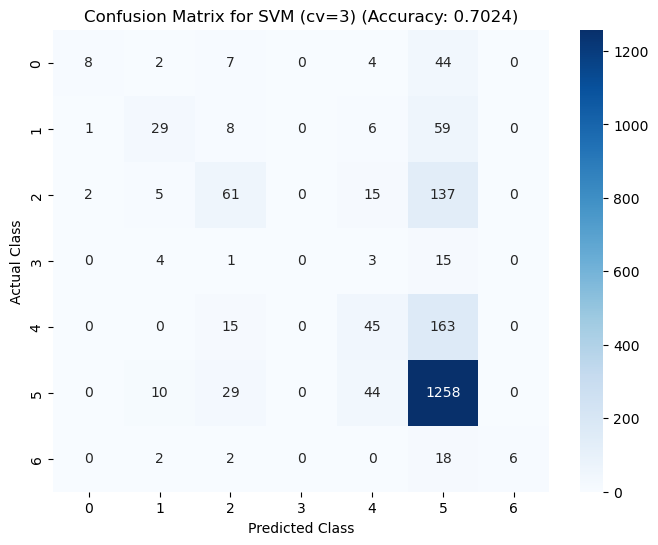

Test Accuracy for saved_models/rbf_svm_cv5.pkl: 0.7024


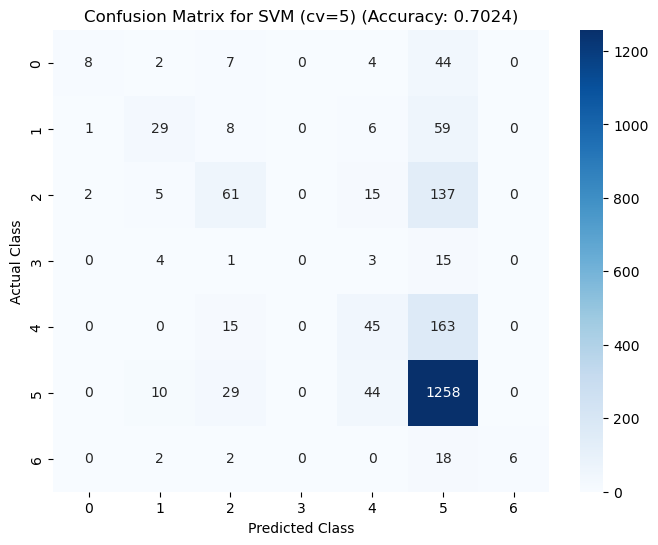

In [61]:
# Paths to saved models
svm_rbf_cv3_path = "saved_models/rbf_svm_cv3.pkl"
svm_rbf_cv5_path = "saved_models/rbf_svm_cv5.pkl"

# Evaluate SVM trained with cv=3
cm_rbf_cv3 = evaluate_svm_model(svm_rbf_cv3_path, X_test_scaled, y_test, title="Confusion Matrix for SVM (cv=3)")

# Evaluate SVM trained with cv=5
cm_rbf_cv5 = evaluate_svm_model(svm_rbf_cv5_path, X_test_scaled, y_test, title="Confusion Matrix for SVM (cv=5)")


In [62]:
# Generate classification report for SVM trained with cv=3
classification_report_cv3_rbf = generate_classification_report(svm_rbf_cv3_path, X_test_scaled, y_test, label_mapping)

# Generate classification report for SVM trained with cv=5
classification_report_cv5_rbf = generate_classification_report(svm_rbf_cv5_path, X_test_scaled, y_test, label_mapping)

c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report for saved_models/rbf_svm_cv3.pkl:

              precision    recall  f1-score   support

       akiec       0.73      0.12      0.21        65
         bcc       0.56      0.28      0.37       103
         bkl       0.50      0.28      0.36       220
          df       0.00      0.00      0.00        23
         mel       0.38      0.20      0.26       223
          nv       0.74      0.94      0.83      1341
        vasc       1.00      0.21      0.35        28

    accuracy                           0.70      2003
   macro avg       0.56      0.29      0.34      2003
weighted avg       0.66      0.70      0.65      2003


Classification Report for saved_models/rbf_svm_cv5.pkl:

              precision    recall  f1-score   support

       akiec       0.73      0.12      0.21        65
         bcc       0.56      0.28      0.37       103
         bkl       0.50      0.28      0.36       220
          df       0.00      0.00      0.00        23
         mel    

c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
rbf_svm_model = joblib.load("saved_models/rbf_svm_cv5.pkl")  # Use cv=3 or cv=5 based on results

# Path to the image you want to classify
image_path = "dataverse_files/ISIC2018_Task3_Test_Images/ISIC_0036063.jpg"  # Replace with actual path

# Extract features from the image
image_features = extract_features_from_image(image_path)

# Predict class
predicted_class = rbf_svm_model.predict(image_features)[0]  # Get predicted class index
print(f"Predicted class index: {predicted_class}")

# Reverse the label mapping dictionary
label_mapping_inv = {v: k for k, v in label_mapping.items()}  # Reverse key-value pairs

# Get predicted class name
predicted_label = label_mapping_inv.get(predicted_class, "Unknown")

print(f"Predicted Skin Condition: {predicted_label}")

1/1 [==============================] - 0s 201ms/step
Predicted class index: 5
Predicted Skin Condition: nv


In [64]:
# Path to the image you want to classify
image_path = "dataverse_files/ISIC2018_Task3_Test_Images/ISIC_0034911.jpg"  # Replace with actual path

# Extract features from the image
image_features = extract_features_from_image(image_path)

# Predict class
predicted_class = rbf_svm_model.predict(image_features)[0]  # Get predicted class index
print(f"Predicted class index: {predicted_class}")

# Reverse the label mapping dictionary
label_mapping_inv = {v: k for k, v in label_mapping.items()}  # Reverse key-value pairs

# Get predicted class name
predicted_label = label_mapping_inv.get(predicted_class, "Unknown")

print(f"Predicted Skin Condition: {predicted_label}")

1/1 [==============================] - 0s 34ms/step
Predicted class index: 5
Predicted Skin Condition: nv


### Random Forest Model 1

In [65]:
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0  # Normalize
    return img

X = []
y = []

for _, row in metadata.iterrows():
    img_path = row["image_path"]
    label = row["dx"]  # Assuming 'dx' is the target class

    if os.path.exists(img_path):  # Ensure the image exists
        img = preprocess_image(img_path)
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        features = feature_extractor.predict(img)[0]  # Extract features
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

1/1 [==============================] - 0s 28ms/step


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
# Define parameter grid for tuning
param_grid = {
    "n_estimators": [200,300],       # Number of trees
    "max_depth": [40, 50],            # Maximum depth of trees
    "min_samples_split": [7,9],      # Min samples to split a node
    "min_samples_leaf": [1, 2],       # Min samples in a leaf
    "max_features": ["sqrt"],         # Number of features per split
    "bootstrap": [True]               # Use bootstrapping
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)


In [50]:
import joblib
### **Grid Search with cv=3**
print("\n--- Performing Grid Search with CV=3 ---")
grid_search_cv3 = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=4
)

grid_search_cv3.fit(X_train, y_train)

# Best parameters from CV=3
best_params_cv3 = grid_search_cv3.best_params_
print("Best Parameters from CV=3:", best_params_cv3)

# Save the best model from CV=3
joblib.dump(grid_search_cv3.best_estimator_, "best_random_forest_cv3.pkl")

# Train the best model with cv=3
best_rf_model_cv3 = grid_search_cv3.best_estimator_
cv3_scores = cross_val_score(best_rf_model_cv3, X_train, y_train, cv=3)

# Print CV=3 results
print(f"\nCross-validation (CV=3) Accuracy Scores: {cv3_scores}")
print(f"Mean CV=3 Accuracy: {cv3_scores.mean():.4f}")

# Make predictions with the CV=3 model
y_pred_cv3 = best_rf_model_cv3.predict(X_test)
accuracy_cv3 = accuracy_score(y_test, y_pred_cv3)
print(f"Tuned Random Forest Accuracy (CV=3 Model): {accuracy_cv3:.4f}")


--- Performing Grid Search with CV=3 ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters from CV=3: {'bootstrap': True, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 300}

Cross-validation (CV=3) Accuracy Scores: [0.70160988 0.70685137 0.70262172]
Mean CV=3 Accuracy: 0.7037
Tuned Random Forest Accuracy (CV=3 Model): 0.7084


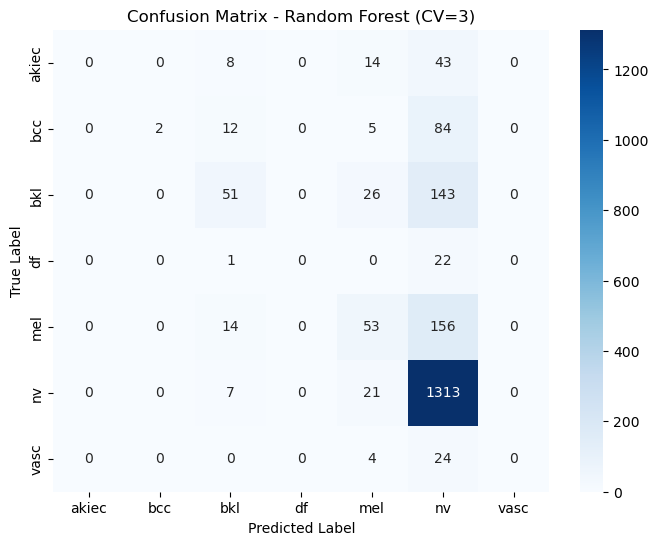

In [51]:
# Generate the confusion matrix
cm_rf_cv3 = confusion_matrix(y_test, y_pred_cv3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_cv3, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest (CV=3)")
plt.show()

In [52]:
# Load the trained Random Forest model
rf_model_cv3 = joblib.load("best_random_forest_cv3.pkl")

# Predict on the test set
y_pred_cv3 = rf_model_cv3.predict(X_test)

# Generate classification report
class_report_rf_cv3 = classification_report(y_test, y_pred_cv3, target_names=label_encoder.classes_)

# Print classification report
print("Classification Report - Random Forest (CV=3):\n")
print(class_report_rf_cv3)

Classification Report - Random Forest (CV=3):

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       1.00      0.02      0.04       103
         bkl       0.55      0.23      0.33       220
          df       0.00      0.00      0.00        23
         mel       0.43      0.24      0.31       223
          nv       0.74      0.98      0.84      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.71      2003
   macro avg       0.39      0.21      0.22      2003
weighted avg       0.65      0.71      0.63      2003



c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
# Define a function to preprocess and predict an image
def predict_image_class(img_path, model, feature_extractor, label_encoder, target_size=(224, 224)):
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Extract features using EfficientNetB0
    features = feature_extractor.predict(img)[0]
    features = np.expand_dims(features, axis=0)  # Reshape for model input

    # Predict class
    prediction = model.predict(features)
    predicted_class = label_encoder.inverse_transform(prediction)[0]

    return predicted_class

In [54]:
image_path = "dataverse_files/ISIC2018_Task3_Test_Images/ISIC_0036063.jpg"
predicted_label = predict_image_class(image_path, rf_model_cv3, feature_extractor, label_encoder)
print(f"Predicted Class: {predicted_label}")

1/1 [==============================] - 0s 26ms/step
Predicted Class: nv


In [55]:
image_path = "dataverse_files/ISIC2018_Task3_Test_Images/ISIC_0034529.jpg"
predicted_label = predict_image_class(image_path, rf_model_cv3, feature_extractor, label_encoder)
print(f"Predicted Class: {predicted_label}")

1/1 [==============================] - 0s 26ms/step
Predicted Class: nv


In [56]:
### **Grid Search with cv=5**
print("\n--- Performing Grid Search with CV=5 ---")
grid_search_cv5 = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_cv5.fit(X_train, y_train)

# Best parameters from CV=5
best_params_cv5 = grid_search_cv5.best_params_
print("Best Parameters from CV=5:", best_params_cv5)

# Save the best model from CV=5
joblib.dump(grid_search_cv5.best_estimator_, "best_random_forest_cv5.pkl")

# Train the best model with cv=5
best_rf_model_cv5 = grid_search_cv5.best_estimator_
cv5_scores = cross_val_score(best_rf_model_cv5, X_train, y_train, cv=5)

# Print CV=5 results
print(f"\nCross-validation (CV=5) Accuracy Scores: {cv5_scores}")
print(f"Mean CV=5 Accuracy: {cv5_scores.mean():.4f}")

# Make predictions with the CV=5 model
y_pred_cv5 = best_rf_model_cv5.predict(X_test)
accuracy_cv5 = accuracy_score(y_test, y_pred_cv5)
print(f"Tuned Random Forest Accuracy (CV=5 Model): {accuracy_cv5:.4f}")


--- Performing Grid Search with CV=5 ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters from CV=5: {'bootstrap': True, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 300}

Cross-validation (CV=5) Accuracy Scores: [0.69868996 0.69868996 0.70848939 0.70599251 0.70349563]
Mean CV=5 Accuracy: 0.7031
Tuned Random Forest Accuracy (CV=5 Model): 0.7044


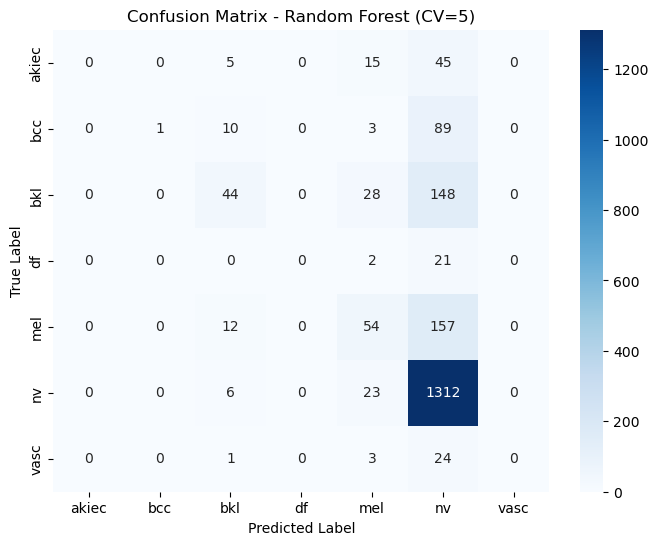

In [57]:
# Generate the confusion matrix
cm_rf_cv5 = confusion_matrix(y_test, y_pred_cv5)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_cv5, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest (CV=5)")
plt.show()

In [58]:
# Load the trained Random Forest model
rf_model_cv5 = joblib.load("best_random_forest_cv5.pkl")

# Predict on the test set
y_pred_cv5 = rf_model_cv5.predict(X_test)

# Generate classification report
class_report_rf_cv5 = classification_report(y_test, y_pred_cv5, target_names=label_encoder.classes_)

# Print classification report
print("Classification Report - Random Forest (CV=5):\n")
print(class_report_rf_cv5)

Classification Report - Random Forest (CV=5):

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       1.00      0.01      0.02       103
         bkl       0.56      0.20      0.30       220
          df       0.00      0.00      0.00        23
         mel       0.42      0.24      0.31       223
          nv       0.73      0.98      0.84      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.70      2003
   macro avg       0.39      0.20      0.21      2003
weighted avg       0.65      0.70      0.63      2003



c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBOOST


In [18]:
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



print(f"✅ Loaded Features - X_train: {X_train_features.shape}, X_test: {X_test_features.shape}")

# ✅ 2. Convert Labels to Numeric Encoding
label_mapping = {label: idx for idx, label in enumerate(sorted(set(y_train)))}
y_train = [label_mapping[label] for label in y_train]
y_test = [label_mapping[label] for label in y_test]

print("✅ Labels converted to numerical encoding:", label_mapping)

# ✅ 3. Train XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=300,  # Number of trees
    max_depth=8,       # Tree depth
    learning_rate=0.01, # Lower learning rate for better generalization
    objective="multi:softmax", # Multiclass classification
    num_class=len(set(y_train)), # Number of classes
    use_label_encoder=False,
    eval_metric="mlogloss"
)

xgb_model.fit(X_train_features, y_train)

# ✅ 4. Predict on Test Set
y_pred = xgb_model.predict(X_test_features)

# ✅ 5. Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Accuracy: {accuracy:.4f}")

# ✅ 6. Display Classification Report
class_report = classification_report(y_test, y_pred)
print("\n✅ Classification Report:\n", class_report)

# ✅ 7. Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("✅ XGBoost Confusion Matrix")
plt.show()

# ✅ 8. Save XGBoost Model
joblib.dump((xgb_model, label_mapping), "saved_models/xgboost.pkl")
print("✅ XGBoost model and label mapping saved successfully!")


✅ Loaded Features - X_train: (6409, 25088), X_test: (2003, 25088)
✅ Labels converted to numerical encoding: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:59] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

✅ XGBoost model and label mapping loaded successfully!


c:\Users\kane\anaconda3\envs\tf_env1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


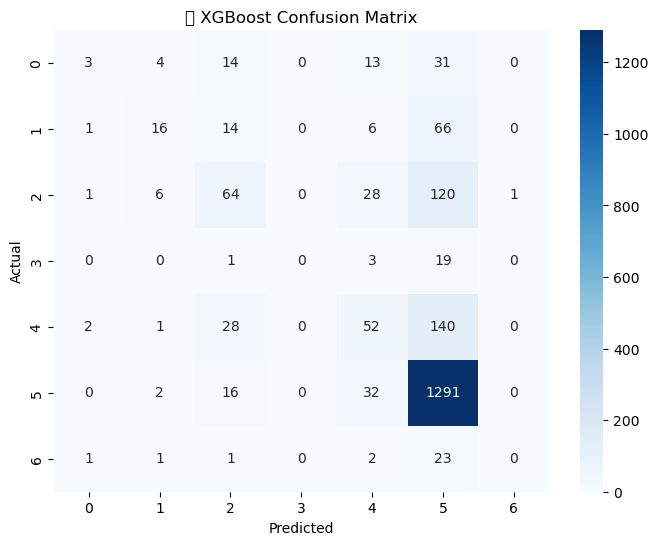

In [19]:
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 1. Load the Saved Model and Label Mapping
xgb_model, label_mapping = joblib.load("saved_models/xgboost.pkl")
print("✅ XGBoost model and label mapping loaded successfully!")

# ✅ 2. Ensure Test Features and Labels are Ready
# Assuming X_test_features and y_test are already loaded and preprocessed
# If y_test is in string format, convert it to numerical encoding using the loaded label_mapping
y_test_encoded = [label_mapping[label] for label in y_test]

# ✅ 3. Predict on Test Set
y_pred = xgb_model.predict(X_test_features)

# ✅ 4. Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# ✅ 5. Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("✅ XGBoost Confusion Matrix")
plt.show()

Top 5 Important Features:
Feature Index 16754: Importance 407.0
Feature Index 12853: Importance 375.0
Feature Index 54: Importance 328.0
Feature Index 9046: Importance 307.0
Feature Index 7684: Importance 306.0


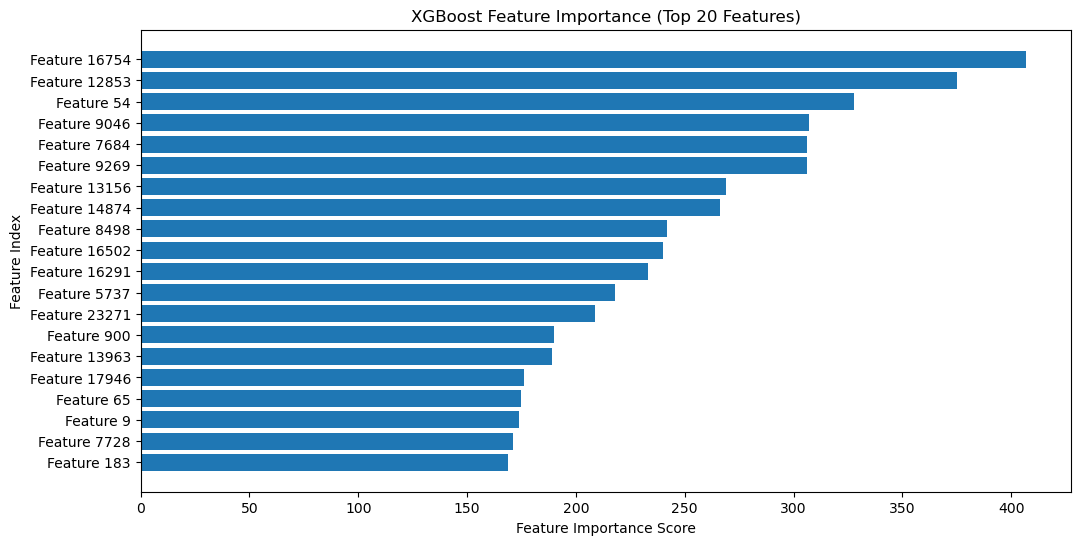

In [68]:
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

# ✅ Load extracted features (from feature.pkl)


# ✅ Load your trained XGBoost model
xgb_model, label_mapping = joblib.load("saved_models/xgboost.pkl")

# ✅ Extract feature importances from the trained model
feature_importance = xgb_model.get_booster().get_score(importance_type="weight")  # Can also use "gain" or "cover"

# ✅ Convert feature importance dictionary to sorted lists
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# ✅ Get feature names (default XGBoost uses f0, f1, f2...) and their importance values
feature_indices = [int(f[0][1:]) for f in sorted_features]  # Convert "f0" to 0, "f1" to 1, etc.
feature_scores = [f[1] for f in sorted_features]

# ✅ Print top 5 most important features
print("Top 5 Important Features:")
for i in range(5):
    print(f"Feature Index {feature_indices[i]}: Importance {feature_scores[i]}")

# ✅ Plot the importance of the top 20 features
plt.figure(figsize=(12, 6))
plt.barh([f"Feature {feature_indices[i]}" for i in range(20)], feature_scores[:20])  # Show top 20 features
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Index")
plt.title("XGBoost Feature Importance (Top 20 Features)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()



🔹 Model Performance Comparison:
             Accuracy  Precision    Recall  F1-Score
SVM (Poly)  0.684973   0.679045  0.684973  0.681345
SVM (RBF)   0.704443   0.662460  0.704443  0.656813
XGBoost     0.711932   0.644533  0.711932  0.656882


<Figure size 800x600 with 0 Axes>

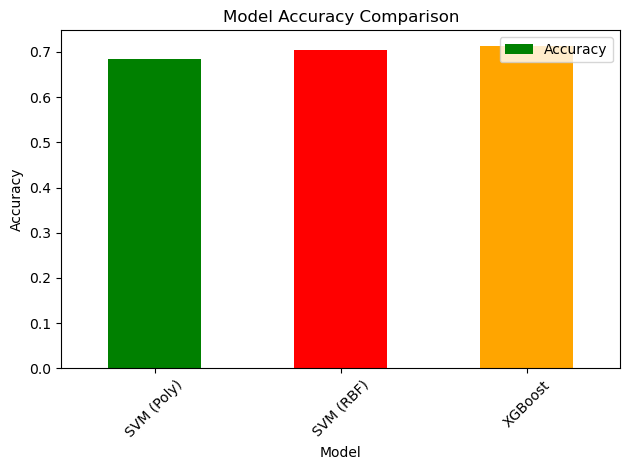

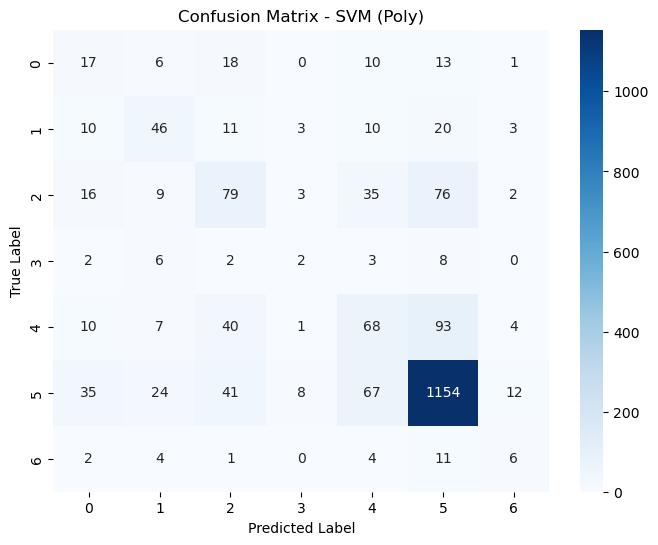

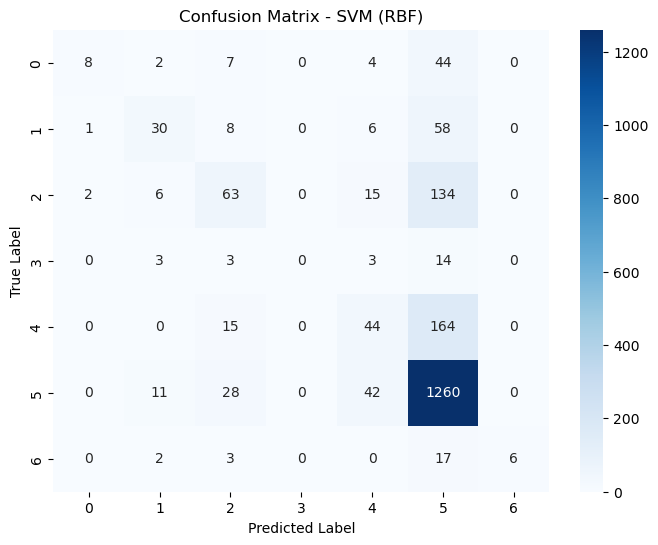

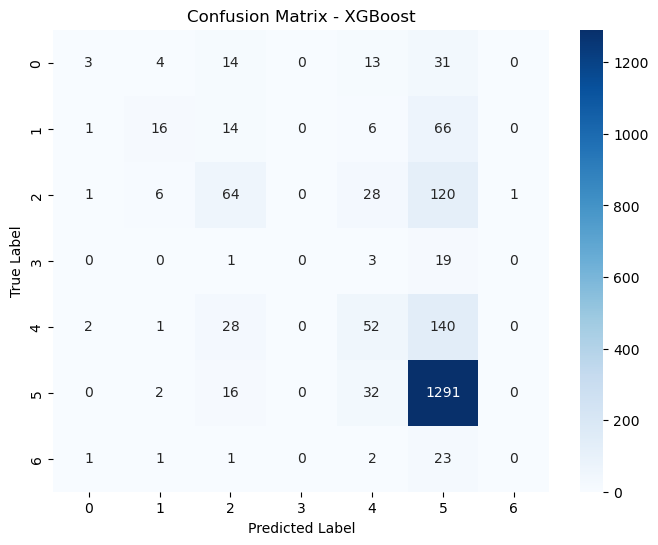

In [16]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import cv2

# --- ✅ 1. Load Models ---
resnet_model = load_model('resnet_model.h5')  # Load CNN Model
poly_svm_model = joblib.load('saved_models/poly_svm_cv5.pkl')  # Load SVM (Poly)
rbf_svm_model = joblib.load('saved_models/rbf_svm_cv5.pkl')  # Load SVM (RBF)
xgb_model, label_mapping = joblib.load("saved_models/xgboost.pkl") 

# --- ✅ 2. Extract Test Image Paths from DataFrame ---
test_image_paths = test['image_path'].tolist()  # Extract file paths from test DataFrame


# 🔹 Ensure CNN model uses raw images, not feature vectors
X_test_images = np.array([
    cv2.resize(cv2.imread(img_path), (224, 224)) / 255.0  
    for img_path in test_image_paths
])
print(f"✅ Fixed X_test_images Shape: {X_test_images.shape}")  # Should be (2003, 224, 224, 3)

# --- ✅ 4. Get Predictions ---
# 🔹 ResNet-50 Prediction (Use Correct Image Input)
y_pred_resnet = resnet_model.predict(X_test_images)
y_pred_resnet = np.argmax(y_pred_resnet, axis=1)  # Convert to class labels

# 🔹 SVM Predictions (Keep Using Flattened Features)
y_pred_svm = poly_svm_model.predict(X_test_scaled)  
y_pred_rbf = rbf_svm_model.predict(X_test_scaled)  
y_pred_xgboost = xgb_model.predict(X_test_features)

# --- ✅ 5. Calculate Evaluation Metrics ---
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

metrics_resnet = calculate_metrics(y_test, y_pred_resnet)
metrics_svm = calculate_metrics(y_test, y_pred_svm)
metrics_rbf = calculate_metrics(y_test, y_pred_rbf)
metrics_xgboost = calculate_metrics(y_test, y_pred_xgboost)

# --- ✅ 6. Create Comparison Table ---
model_names = ['ResNet50', 'SVM (Poly)', 'SVM (RBF)', 'XGBoost']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_data = [metrics_resnet, metrics_svm, metrics_rbf, metrics_xgboost]

comparison_df = pd.DataFrame(metrics_data, index=model_names, columns=metric_names)
print("\n🔹 Model Performance Comparison:\n", comparison_df)

# --- ✅ 7. Visualize Model Performance ---
plt.figure(figsize=(8, 6))
comparison_df.plot(kind='bar', y='Accuracy', color=['blue', 'green', 'red', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- ✅ 8. Confusion Matrices ---
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# 🔹 Plot Confusion Matrices for Each Model
plot_confusion_matrix(y_test, y_pred_resnet, "ResNet50")
plot_confusion_matrix(y_test, y_pred_svm, "SVM (Poly)")
plot_confusion_matrix(y_test, y_pred_rbf, "SVM (RBF)")
plot_confusion_matrix(y_test, y_pred_xgboost, "XGBoost")
